In [38]:
import numpy as np

def generate_condind_dataset(n=10000, d=15, true_label_prob=0.5, seed=42):
    np.random.seed(seed)
    
    # Menghasilkan true label (0 atau 1)
    Y_true = np.random.binomial(1, true_label_prob, size=n)

    # Sensitivitas dan spesifisitas untuk classifier yang berguna
    good_sens = 0.9  # P(pred=1 | Y=1)
    good_spec = 0.9  # P(pred=0 | Y=0)

    # Menghasilkan prediksi dari 5 classifier yang baik
    X_good = np.zeros((n, 5))
    for i in range(5):
        X_good[Y_true == 1, i] = np.random.binomial(1, good_sens, size=(Y_true == 1).sum())
        X_good[Y_true == 0, i] = np.random.binomial(1, 1 - good_spec, size=(Y_true == 0).sum())

    # Menghasilkan prediksi dari 10 classifier acak (akurasi ~ 50%)
    X_rand = np.random.binomial(1, 0.5, size=(n, 10))

    # Gabungkan semua classifier
    X_total = np.hstack([X_good, X_rand])
    return X_total, Y_true


In [39]:
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

# Men generate data
X, y_true = generate_condind_dataset()

# Melatih RBM dengan 1 hidden unit
rbm = BernoulliRBM(n_components=1, learning_rate=0.05, batch_size=10, n_iter=20, random_state=42)
rbm.fit(X)

# Mendapatkan aktivasi tersembunyi (probabilitas H=1 diberikan X)
H = rbm.transform(X)  # bentuk (n_samples, 1)

# Menggunakan regresi logistik untuk mempelajari pemetaan H -> Y (meniru EM)
clf = LogisticRegression()
clf.fit(H, y_true)
y_pred = clf.predict(H)

# Evaluasi
score = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {score:.4f}")


Balanced Accuracy: 0.9914


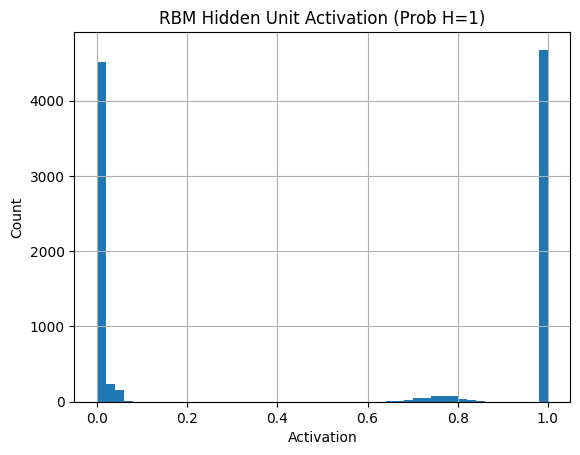

In [40]:
import matplotlib.pyplot as plt

plt.hist(H, bins=50)
plt.title("RBM Hidden Unit Activation (Prob H=1)")
plt.xlabel("Activation")
plt.ylabel("Count")
plt.grid(True)
plt.show()


menggunakan dataset berbeda

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Load data
data = load_breast_cancer()
# Skala fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.data)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, data.target, test_size=0.3, random_state=42)

# Daftar model (anggap sebagai "annotator")
models = [
    LogisticRegression(max_iter=500),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(probability=True),
    GaussianNB()
]


# Buat output prediksi dari masing-masing model (binarized)
preds = []
for model in models:
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    binarized = Binarizer(threshold=0.5).fit_transform(probs.reshape(-1, 1)).flatten()
    preds.append(binarized)

# Combine jadi data matrix (annotator output)
X_annotator = np.vstack(preds).T

In [42]:
# Ini mirip kayak replikasi tadi
rbm = BernoulliRBM(n_components=3, learning_rate=0.05, batch_size=10, n_iter=30, random_state=42)

rbm.fit(X_annotator)

# Hidden representation
H = rbm.transform(X_annotator)

# Belajar label (buat evaluasi)
clf = LogisticRegression()
clf.fit(H, y_test)
y_pred = clf.predict(H)

# Balanced Accuracy
score = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy (Real Dataset): {score:.4f}")


Balanced Accuracy (Real Dataset): 0.9444


In [43]:
for i, pred in enumerate(preds):
    acc = balanced_accuracy_score(y_test, pred)
    print(f"Model {i+1} Akurasi Seimbang: {acc:.3f}")


Model 1 Akurasi Seimbang: 0.983
Model 2 Akurasi Seimbang: 0.959
Model 3 Akurasi Seimbang: 0.954
Model 4 Akurasi Seimbang: 0.961
Model 5 Akurasi Seimbang: 0.929


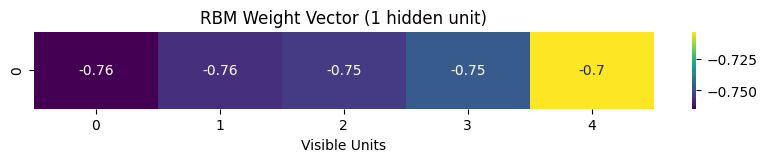

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil bobot dari RBM
weights = rbm.components_[0]  # Karena cuma 1 hidden unit

plt.figure(figsize=(10, 1))
sns.heatmap(weights.reshape(1, -1), cmap="viridis", cbar=True, annot=True)
plt.xlabel("Visible Units")
plt.title("RBM Weight Vector (1 hidden unit)")
plt.show()


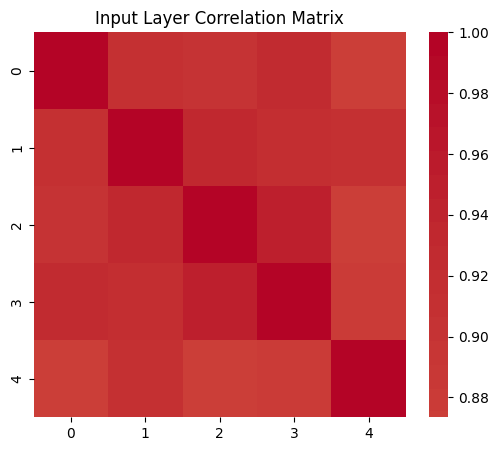

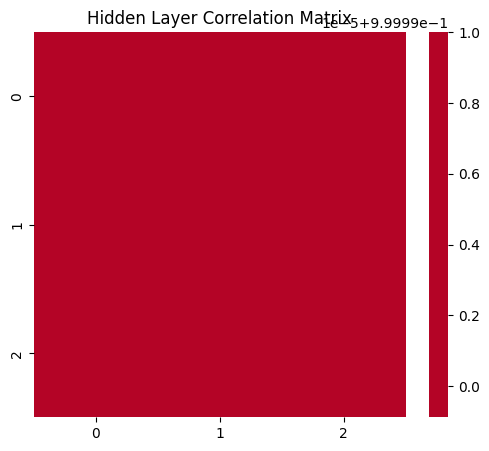

In [45]:
def plot_corr_matrix(data, title="Correlation Matrix"):
    corr = np.corrcoef(data.T)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(title)
    plt.show()

# Untuk input
plot_corr_matrix(X_annotator, "Input Layer Correlation Matrix")

# Untuk hidden layer (hasil RBM)
plot_corr_matrix(H, "Hidden Layer Correlation Matrix")
